In [5]:
import os
from typing import List, Tuple
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_openai import AzureOpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import AzureChatOpenAI
from langchain.prompts import ChatPromptTemplate
from rank_bm25 import BM25Okapi
import cohere
import logging
import time
from llama_parse import LlamaParse
from azure.ai.documentintelligence.models import DocumentAnalysisFeature
from langchain_community.document_loaders.doc_intelligence import AzureAIDocumentIntelligenceLoader

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
load_dotenv('azure.env', override=True)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/mrajguru/.config/sagemaker/config.yaml


True

In [18]:
class ContextualRetrieval:
    def __init__(self):
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=800,
            chunk_overlap=100,
        )
        self.embeddings = AzureOpenAIEmbeddings(
                            api_key=os.getenv("AZURE_OPENAI_API_KEY"),
                            azure_deployment="text-embedding-ada-002",
                            openai_api_version="2024-03-01-preview",
                            azure_endpoint =os.environ["AZURE_OPENAI_ENDPOINT"]
                        )
        self.llm = AzureChatOpenAI(
            api_key=os.environ["AZURE_OPENAI_API_KEY"],
            azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
            azure_deployment="gpt-4o",
            temperature=0,
            max_tokens=None,
            timeout=None,
            max_retries=2,
        )
        self.cohere_client = cohere.Client(os.getenv("COHERE_API_KEY"))

    def load_pdf_with_llama_parse(self, pdf_path: str) -> str:
        loader = AzureAIDocumentIntelligenceLoader(file_path=pdf_path, 
                                           api_key = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_KEY"), 
                                           api_endpoint = os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT"),
                                           api_model="prebuilt-layout",
                                           api_version="2024-02-29-preview",
                                           mode='markdown',
                                           analysis_features = [DocumentAnalysisFeature.OCR_HIGH_RESOLUTION])

        try:
            documents = loader.load()
            if not documents:
                raise ValueError("No content extracted from the PDF.")
            return " ".join([doc.page_content for doc in documents])
        except Exception as e:
            logging.error(f"Error while parsing the file '{pdf_path}': {str(e)}")
            raise

    def process_document(self, document: str) -> Tuple[List[Document], List[Document]]:
        if not document.strip():
            raise ValueError("The document is empty after parsing.")
        chunks = self.text_splitter.create_documents([document])
        contextualized_chunks = self._generate_contextualized_chunks(document, chunks)
        return chunks, contextualized_chunks

    def _generate_contextualized_chunks(self, document: str, chunks: List[Document]) -> List[Document]:
        contextualized_chunks = []
        for chunk in chunks:
            context = self._generate_context(document, chunk.page_content)
            contextualized_content = f"{context}\n\n{chunk.page_content}"
            contextualized_chunks.append(Document(page_content=contextualized_content, metadata=chunk.metadata))
        return contextualized_chunks

    def _generate_context(self, document: str, chunk: str) -> str:
        prompt = ChatPromptTemplate.from_template("""
        You are an AI assistant specializing in document analysis. Your task is to provide brief, relevant context for a chunk of text from the given document.
        Here is the document:
        <document>
        {document}
        </document>

        Here is the chunk we want to situate within the whole document:
        <chunk>
        {chunk}
        </chunk>

        Provide a concise context (2-3 sentences) for this chunk, considering the following guidelines:
        1. Identify the main topic or concept discussed in the chunk.
        2. Mention any relevant information or comparisons from the broader document context.
        3. If applicable, note how this information relates to the overall theme or purpose of the document.
        4. Include any key figures, dates, or percentages that provide important context.
        5. Do not use phrases like "This chunk discusses" or "This section provides". Instead, directly state the context.

        Please give a short succinct context to situate this chunk within the overall document for the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else.

        Context:
        """)
        messages = prompt.format_messages(document=document, chunk=chunk)
        response = self.llm.invoke(messages)
        return response.content

    def create_bm25_index(self, chunks: List[Document]) -> BM25Okapi:
        tokenized_chunks = [chunk.page_content.split() for chunk in chunks]
        return BM25Okapi(tokenized_chunks)

    def generate_answer(self, query: str, relevant_chunks: List[str]) -> str:
        prompt = ChatPromptTemplate.from_template("""
        Based on the following information, please provide a concise and accurate answer to the question.
        If the information is not sufficient to answer the question, say so.

        Question: {query}

        Relevant information:
        {chunks}

        Answer:
        """)
        messages = prompt.format_messages(query=query, chunks="\n\n".join(relevant_chunks))
        response = self.llm.invoke(messages)
        return response.content

    def rerank_results(self, query: str, documents: List[Document], top_n: int = 3) -> List[Document]:
        logging.info(f"Reranking {len(documents)} documents for query: {query}")
        doc_contents = [doc.page_content for doc in documents]
        
        max_retries = 3
        for attempt in range(max_retries):
            try:
                reranked = self.cohere_client.rerank(
                    model="rerank-english-v2.0",
                    query=query,
                    documents=doc_contents,
                    top_n=top_n
                )
                break
            except cohere.errors.TooManyRequestsError:
                if attempt < max_retries - 1:
                    logging.warning(f"Rate limit hit. Waiting for 60 seconds before retry {attempt + 1}/{max_retries}")
                    time.sleep(60)  # Wait for 60 seconds before retrying
                else:
                    logging.error("Rate limit hit. Max retries reached. Returning original documents.")
                    return documents[:top_n]
        
        logging.info(f"Reranking complete. Top {top_n} results:")
        reranked_docs = []
        for idx, result in enumerate(reranked.results):
            original_doc = documents[result.index]
            reranked_docs.append(original_doc)
            logging.info(f"  {idx+1}. Score: {result.relevance_score:.4f}, Index: {result.index}")
        
        return reranked_docs

    def expand_query(self, original_query: str) -> str:
        prompt = ChatPromptTemplate.from_template("""
        You are an AI assistant specializing in document analysis. Your task is to expand the given query to include related terms and concepts that might be relevant for a more comprehensive search of the document.

        Original query: {query}

        Please provide an expanded version of this query, including relevant terms, concepts, or related ideas that might help in summarizing the full document. The expanded query should be a single string, not a list.

        Expanded query:
        """)
        messages = prompt.format_messages(query=original_query)
        response = self.llm.invoke(messages)
        return response.content

In [19]:
cr = ContextualRetrieval()
pdf_path = "1.pdf"
document = cr.load_pdf_with_llama_parse(pdf_path)

2024-10-14 20:31:28,103 - INFO - Request URL: 'https://new-one-mano.cognitiveservices.azure.com//documentintelligence/documentModels/prebuilt-layout:analyze?api-version=REDACTED&outputContentFormat=REDACTED'
Request method: 'POST'
Request headers:
    'content-type': 'application/octet-stream'
    'Accept': 'application/json'
    'x-ms-client-request-id': '30604c42-8a3d-11ef-936a-7f617eccfa68'
    'x-ms-useragent': 'REDACTED'
    'User-Agent': 'azsdk-python-ai-documentintelligence/1.0.0b4 Python/3.10.12 (Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.35)'
    'Ocp-Apim-Subscription-Key': 'REDACTED'
A body is sent with the request
2024-10-14 20:31:35,461 - INFO - Response status: 202
Response headers:
    'Content-Length': '0'
    'Operation-Location': 'REDACTED'
    'x-envoy-upstream-service-time': 'REDACTED'
    'apim-request-id': 'REDACTED'
    'Strict-Transport-Security': 'REDACTED'
    'x-content-type-options': 'REDACTED'
    'x-ms-region': 'REDACTED'
    'Date': 'Tue,

In [67]:
def process_query(cr, query, contextualized_bm25_index, contextualized_chunks):
    try:
        # Retrieve from contextualized BM25
        contextualized_tokenized_query = query.split()
        contextualized_bm25_results = contextualized_bm25_index.get_top_n(contextualized_tokenized_query, contextualized_chunks, n=10)
        reranked_contextualized_bm25 = cr.rerank_results(query, contextualized_bm25_results)
        contextualized_bm25_answer = cr.generate_answer(query, [doc.page_content for doc in reranked_contextualized_bm25])
        return contextualized_bm25_answer
    except Exception as e:
        logging.error(f"An error occurred during query processing: {str(e)}")

In [ ]:
# Process the document
_, contextualized_chunks = cr.process_document(document)

# Create BM25 index
contextualized_bm25_index = cr.create_bm25_index(contextualized_chunks)

# Original query for summarization
original_query = "Summarize the full in detail document and also explain in detail the Fixture limits"
print(f"\nOriginal Query: {original_query}")
process_query(cr, original_query, contextualized_bm25_index, contextualized_chunks)

# Expanded query
expanded_query = cr.expand_query(original_query)
print(f"\nExpanded Query: {expanded_query}")
process_query(cr, expanded_query, contextualized_bm25_index, contextualized_chunks)

In [35]:
from langchain.text_splitter import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]
text_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

docs_result = text_splitter.split_text(document)

print("Length of splits: " + str(len(docs_result)))

Length of splits: 11


In [36]:
from azure.ai.generative.synthetic.qa import QADataGenerator, QAType

In [15]:
# ---------------------------------------------------------
# Copyright (c) Microsoft Corporation. All rights reserved.
# ---------------------------------------------------------

"""Question-Answer Data Generator."""

try:
    import asyncio
    import os
    import time
    from enum import Enum
    from functools import lru_cache
    from packaging import version
    from typing import Dict, List, Tuple, Any, Union, Optional
    from collections import defaultdict
    from azure.ai.generative.constants._common import USER_AGENT_HEADER_KEY
    from azure.ai.generative._telemetry import ActivityType, monitor_with_activity, ActivityLogger
    from azure.core import CaseInsensitiveEnumMeta
    from azure.core.tracing.decorator import distributed_trace
    from azure.ai.generative._user_agent import USER_AGENT
except ImportError as e:
    print("In order to use qa, please install the 'qa_generation' extra of azure-ai-generative")
    raise e

try:
    import pkg_resources  # type: ignore[import]

    openai_version_str = pkg_resources.get_distribution("openai").version
    openai_version = pkg_resources.parse_version(openai_version_str)
    import openai

    if openai_version >= pkg_resources.parse_version("1.0.0"):
        _RETRY_ERRORS: Tuple = (openai.APIConnectionError, openai.APIError, openai.APIStatusError)
    else:
        _RETRY_ERRORS: Tuple = (  # type: ignore[no-redef]
            openai.error.ServiceUnavailableError,  # pylint: disable=no-member
            openai.error.APIError,  # pylint: disable=no-member
            openai.error.RateLimitError,  # pylint: disable=no-member
            openai.error.APIConnectionError,  # pylint: disable=no-member
            openai.error.Timeout,  # pylint: disable=no-member
        )

except ImportError as e:
    print("In order to use qa, please install the 'qa_generation' extra of azure-ai-generative")
    raise e

_TEMPLATES_DIR = "templates"#os.path.join(os.path.dirname(os.path.abspath(__file__)), "templates")
activity_logger = ActivityLogger(__name__)
logger, module_logger = activity_logger.package_logger, activity_logger.module_logger

_DEFAULT_AOAI_VERSION = "2023-07-01-preview"
_MAX_RETRIES = 7


def _completion_with_retries(*args, **kwargs):
    n = 1
    while True:
        try:
            if openai_version >= pkg_resources.parse_version("1.0.0"):
                if kwargs["api_type"].lower() == "azure":
                    from openai import AzureOpenAI

                    client = AzureOpenAI(
                        azure_endpoint=kwargs["api_base"],
                        api_key=kwargs["api_key"],
                        api_version=kwargs["api_version"],
                        default_headers={USER_AGENT_HEADER_KEY: USER_AGENT},
                    )
                    response = client.chat.completions.create(
                        messages=kwargs["messages"],
                        model=kwargs["deployment_id"],
                        temperature=kwargs["temperature"],
                        max_tokens=kwargs["max_tokens"],
                    )
                else:
                    from openai import OpenAI

                    client = OpenAI(
                        api_key=kwargs["api_key"],
                        default_headers={USER_AGENT_HEADER_KEY: USER_AGENT},
                    )
                    response = client.chat.completions.create(
                        messages=kwargs["messages"],
                        model=kwargs["model"],
                        temperature=kwargs["temperature"],
                        max_tokens=kwargs["max_tokens"],
                    )
                return response.choices[0].message.content, dict(response.usage)
            response = openai.ChatCompletion.create(*args, **kwargs)  # pylint: disable=no-member
            return response["choices"][0].message.content, response["usage"]
        except _RETRY_ERRORS as _re:  # pylint: disable=catching-non-exception
            if n > _MAX_RETRIES:
                raise
            secs = 2**n
            msg = f"Retrying after {secs}s. API call failed due to {_re.__class__.__name__}: {_re}"
            logger.warning(msg)
            time.sleep(secs)
            n += 1
            continue


async def _completion_with_retries_async(*args, **kwargs):
    n = 1
    while True:
        try:
            if openai_version >= pkg_resources.parse_version("1.0.0"):
                if kwargs["api_type"].lower() == "azure":
                    from openai import AsyncAzureOpenAI

                    client = AsyncAzureOpenAI(
                        azure_endpoint=kwargs["api_base"],
                        api_key=kwargs["api_key"],
                        api_version=kwargs["api_version"],
                        default_headers={USER_AGENT_HEADER_KEY: USER_AGENT},
                    )
                    response = await client.chat.completions.create(
                        messages=kwargs["messages"],
                        model=kwargs["deployment_id"],
                        temperature=kwargs["temperature"],
                        max_tokens=kwargs["max_tokens"],
                    )
                else:
                    from openai import AsyncOpenAI

                    client = AsyncOpenAI(
                        api_key=kwargs["api_key"],
                        default_headers={USER_AGENT_HEADER_KEY: USER_AGENT},
                    )
                    response = await client.chat.completions.create(
                        messages=kwargs["messages"],
                        model=kwargs["model"],
                        temperature=kwargs["temperature"],
                        max_tokens=kwargs["max_tokens"],
                    )
                return response.choices[0].message.content, dict(response.usage)
            response = openai.ChatCompletion.create(*args, **kwargs)  # pylint: disable=no-member
            return response["choices"][0].message.content, response["usage"]
        except _RETRY_ERRORS as _re:  # pylint: disable=catching-non-exception
            if n > _MAX_RETRIES:
                raise
            secs = 2**n
            logger.warning("Retrying after %ss. API call failed due to %s: %s", secs, _re.__class__.__name__, _re)
            await asyncio.sleep(secs)
            n += 1
            continue


class OutputStructure(str, Enum, metaclass=CaseInsensitiveEnumMeta):
    """OutputStructure defines what structure the QAs should be written to file in."""

    PROMPTFLOW = "PROMPTFLOW"
    """Chat history will be in format used by promptflow"""
    CHAT_PROTOCOL = "CHAT_PROTOCOL"
    """QAs will be in OpenAI message format"""


class QAType(str, Enum, metaclass=CaseInsensitiveEnumMeta):
    """QAType defines different types of QAs that can be generated."""

    SHORT_ANSWER = "SHORT_ANSWER"
    """
        Short answer QAs have answers that are only a few words long.
        These words are generally relevant details from text like dates, names, statistics, etc.
    """
    LONG_ANSWER = "LONG_ANSWER"
    """
        Long answer QAs have answers that are one or more sentences long.
        ex. Questions where answer is a definition: What is a {topic_from_text}?
    """
    BOOLEAN = "BOOLEAN"
    """Boolean QAs have answers that are either True or False."""
    SUMMARY = "SUMMARY"
    """
        Summary QAs have questions that ask to write a summary for text's title in a limited number of words.
        It generates just one QA.
    """
    CONVERSATION = "CONVERSATION"
    """
        Conversation QAs have questions that might reference words or ideas from previous QAs.
        ex. If previous conversation was about some topicX from text, next question might reference it
        without using its name: How does *it* compare to topicY?
    """


class QADataGenerator:
    """Class for generating Question-Answer data from text."""

    _PARSING_ERR_UNEQUAL_QA = "Parsing error: Unequal question answer count"
    _PARSING_ERR_UNEQUAL_Q_AFTER_MOD = "Parsing error: Unequal question count after modification"
    _PARSING_ERR_FIRST_LINE = "Parsing error: First line must be a question"

    def __init__(self, model_config: Dict):
        """Initialize QADataGenerator using Azure OpenAI details."""

        api_key = "OPENAI_API_KEY"
        api_base = "OPENAI_API_BASE"
        if version.parse(openai.version.VERSION) >= version.parse("1.0.0"):
            api_key = "AZURE_OPENAI_KEY"
            api_base = "AZURE_OPENAI_ENDPOINT"
        self._chat_completion_params = dict(
            # AOAI connection params
            api_type=model_config["api_type"] if "api_type" in model_config else os.getenv("OPENAI_API_TYPE", "azure"),
            api_version=model_config["api_version"]
            if "api_version" in model_config
            else os.getenv("OPENAI_API_VERSION", _DEFAULT_AOAI_VERSION),
            api_base=model_config["api_base"] if "api_base" in model_config else os.getenv(api_base),
            api_key=model_config["api_key"] if "api_key" in model_config else os.getenv(api_key),
            # AOAI model params
            deployment_id=model_config["deployment"],
            model=model_config["model"],
            max_tokens=model_config.get("max_tokens", 2000),
            temperature=0.0,  # don't need creativity
        )
        print(self._chat_completion_params)
        activity_logger.update_info()

    def _validate(self, qa_type: QAType, num_questions: Optional[int]):
        if qa_type == QAType.SUMMARY and num_questions is not None:
            raise ValueError("num_questions unsupported for Summary QAType")
        if qa_type != QAType.SUMMARY and num_questions <= 0:  # type: ignore[operator]
            raise ValueError("num_questions must be an integer greater than zero")

    def _get_messages_for_qa_type(self, qa_type: QAType, text: str, num_questions: int) -> List:
        logger.debug("Getting prompt messages for %s QA type", qa_type)
        template_filename = {
            QAType.SHORT_ANSWER: "prompt_qa_short_answer.txt",
            QAType.LONG_ANSWER: "prompt_qa_long_answer.txt",
            QAType.BOOLEAN: "prompt_qa_boolean.txt",
            QAType.SUMMARY: "prompt_qa_summary.txt",
            QAType.CONVERSATION: "prompt_qa_conversation.txt",
        }
        filename = template_filename[qa_type]
        messages = self._get_messages_from_file(filename)
        input_variables: Dict[str, Any] = {"text": text}
        if qa_type == QAType.SUMMARY:
            input_variables["num_words"] = 100
        else:
            input_variables["num_questions"] = num_questions
        messages[-1]["content"] = messages[-1]["content"].format(**input_variables)
        return messages

    def _get_messages_for_modify_conversation(self, questions: List[str]) -> List:
        messages = self._get_messages_from_file("prompt_qa_conversation_modify.txt")
        questions_str = "\n".join([f"[Q]: {q}" for q in questions])
        messages[-1]["content"] = messages[-1]["content"].format(questions=questions_str)
        return messages

    def _get_messages_from_file(self, filename: str) -> List:
        template = self._get_template(filename)
        content_list = [content.strip() for content in template.split("<|separator|>")]
        messages = [
            {"role": "system", "content": content_list[0]},  # system instructions
            {"role": "user", "content": content_list[1]},  # few-shot input
            {"role": "assistant", "content": content_list[2]},  # few-shot output
            {"role": "user", "content": content_list[3]},  # input template
        ]
        return messages

    @lru_cache
    def _get_template(self, filename) -> str:
        logger.debug("Getting prompt template from %s file", filename)
        filepath = os.path.join(_TEMPLATES_DIR, filename)
        with open(filepath, encoding="utf-8") as f:
            template = f.read()
        return template

    def _parse_qa_from_response(self, response_text: str) -> Tuple[List[str], List[str]]:
        print("response_text", response_text)
        q_prefix, a_prefix = "[Q]: ", "[A]: "
        last_updated = None
        questions, answers = [], []
        for line in response_text.split("\n"):
            if line.startswith(q_prefix):
                questions.append(line[len(q_prefix) :])
                last_updated = "Q"
            elif line.startswith(a_prefix):
                answers.append(line[len(a_prefix) :])
                last_updated = "A"
            else:  # Q or A spread across multiple lines
                assert last_updated is not None, self._PARSING_ERR_FIRST_LINE
                if last_updated == "Q":
                    questions[-1] += "\n" + line
                else:
                    answers[-1] += "\n" + line
        return questions, answers

    def _merge_token_usage(self, token_usage: Dict, token_usage2: Dict) -> Dict:
        return {name: count + token_usage[name] for name, count in token_usage2.items()}

    def _modify_conversation_questions(self, questions) -> Tuple[List[str], Dict]:
        content, usage = _completion_with_retries(
            messages=self._get_messages_for_modify_conversation(questions),
            **self._chat_completion_params,
        )

        modified_questions, _ = self._parse_qa_from_response(content)
        # Keep proper nouns in first question of conversation
        modified_questions[0] = questions[0]
        assert len(modified_questions) == len(questions), self._PARSING_ERR_UNEQUAL_Q_AFTER_MOD
        return modified_questions, usage

    @distributed_trace
    @monitor_with_activity(logger, "QADataGenerator.Export", ActivityType.INTERNALCALL)
    def export_to_file(
        self,
        output_path: str,
        qa_type: QAType,
        results: Union[List, List[List]],
        output_format: OutputStructure = OutputStructure.PROMPTFLOW,
        field_mapping: Optional[Dict[str, str]] = None,
    ):
        """
        Writes results from QA gen to a jsonl file for Promptflow batch run results is either a list of questions
        and answers or list of list of questions and answers grouped by their chunk e.g. [("How are you?",
        "I am good.")] or [ [("How are you?", "I am good.")], [("What can I do?", "Tell me a joke.")].

        :param output_path: The path to the output file.
        :type output_path: str
        :param qa_type: The type of QA data.
        :type qa_type: QAType
        :param results: The results of the QA generation.
        :type results: Union[List, List[List]]
        :param output_format: The output structure format.
        :type output_format: OutputStructure, optional
        :param field_mapping: The field mapping for the output structure.
        :type field_mapping: Optional[Dict[str, str]], optional
        """
        data_dict = defaultdict(list)

        if field_mapping is None:
            field_mapping = {"chat_history_key": "chat_history", "question_key": "question"}

        if not isinstance(results[0], List):
            results = [results]

        if output_format == OutputStructure.PROMPTFLOW:

            if qa_type == QAType.CONVERSATION and not (
                "chat_history_key" in field_mapping and "question_key" in field_mapping
            ):
                keys = "chat_history_key, question_key"
                raise Exception(
                    "Field mapping for Promptflow output with Conversation must contain following keys: " + keys
                )
            # Only the question key is required in non-conversation cases,
            # we can default to chat_history as chat_history_key
            if "question_key" not in field_mapping:
                raise Exception(
                    f"Field mapping for Promptflow output with {qa_type} must contain following keys: question_key"
                )

            question_key = field_mapping["question_key"]
            # Set this here for parity with eval flows
            answer_key = "ground_truth"
            chat_history_key = field_mapping.get("chat_history_key", "chat_history")
            for qs_and_as in results:
                chat_history: List = []
                for question, answer in qs_and_as:
                    data_dict[chat_history_key].append(list(chat_history))
                    if qa_type == QAType.CONVERSATION:
                        # Chat History columns:
                        data_dict[question_key].append(question)
                        chat_history.append({"inputs": {question_key: question}, "outputs": {answer_key: answer}})
                    else:
                        # QnA columns:
                        data_dict[question_key].append(question)

                    data_dict[answer_key].append(answer)  # Consider generated answer as the ground truth
        else:
            for qs_and_as in results:
                chat_history = []
                for question, answer in qs_and_as:
                    if qa_type == QAType.CONVERSATION:
                        print(f"Chat data dict: {data_dict['messages']}\n\n")
                        chat_history.append({"role": "user", "content": question})
                        chat_history.append({"role": "assistant", "content": answer})
                        data_dict["messages"].append(list(chat_history))
                    else:
                        messages = []
                        messages.append({"role": "user", "content": question})
                        messages.append({"role": "assistant", "content": answer})
                        data_dict["messages"].append(list(messages))
        # export to jsonl file
        try:
            import pandas as pd
        except ImportError as ie:
            print("In order to write qa data to file, please install pandas")
            raise ie

        data_df = pd.DataFrame(data_dict, columns=list(data_dict.keys()))
        data_df.to_json(output_path, lines=True, orient="records")

    @distributed_trace
    @monitor_with_activity(logger, "QADataGenerator.Generate", ActivityType.INTERNALCALL)
    def generate(self, text: str, qa_type: QAType, num_questions: Optional[int] = None) -> Dict:
        self._validate(qa_type, num_questions)
        validated_num_questions: int = num_questions  # type: ignore[assignment]
        content, token_usage = _completion_with_retries(
            messages=self._get_messages_for_qa_type(qa_type, text, validated_num_questions),
            **self._chat_completion_params,
        )
        questions, answers = self._parse_qa_from_response(content)
        assert len(questions) == len(answers), self._PARSING_ERR_UNEQUAL_QA
        if qa_type == QAType.CONVERSATION:
            questions, token_usage2 = self._modify_conversation_questions(questions)
            print("token_usage2", token_usage2)
            token_usage = self._merge_token_usage(token_usage, token_usage2)
        return {
            "question_answers": list(zip(questions, answers)),
            "token_usage": token_usage,
        }

    async def _modify_conversation_questions_async(self, questions) -> Tuple[List[str], Dict]:
        content, usage = await _completion_with_retries_async(
            messages=self._get_messages_for_modify_conversation(questions),
            **self._chat_completion_params,
        )

        modified_questions, _ = self._parse_qa_from_response(content)
        # Keep proper nouns in first question of conversation
        modified_questions[0] = questions[0]
        assert len(modified_questions) == len(questions), self._PARSING_ERR_UNEQUAL_Q_AFTER_MOD
        return modified_questions, usage

    @distributed_trace
    @monitor_with_activity(logger, "QADataGenerator.GenerateAsync", ActivityType.INTERNALCALL)
    async def generate_async(self, text: str, qa_type: QAType, num_questions: Optional[int] = None) -> Dict:
        self._validate(qa_type, num_questions)
        validated_num_questions: int = num_questions  # type: ignore[assignment]
        content, token_usage = await _completion_with_retries_async(
            messages=self._get_messages_for_qa_type(qa_type, text, validated_num_questions),
            **self._chat_completion_params,
        )
        questions, answers = self._parse_qa_from_response(content)
        assert len(questions) == len(answers), self._PARSING_ERR_UNEQUAL_QA
        if qa_type == QAType.CONVERSATION:
            questions, token_usage2 = await self._modify_conversation_questions_async(questions)
            token_usage = self._merge_token_usage(token_usage, token_usage2)
        return {
            "question_answers": list(zip(questions, answers)),
            "token_usage": token_usage,
        }

In [39]:
model_config = {
    "deployment": "gpt-4o",
    "model": "gpt-4o",
    "max_tokens": 3500
}

qa_generator = QADataGenerator(model_config=model_config)

In [42]:
import asyncio
from collections import Counter
from typing import Dict

concurrency = 3  # number of concurrent calls
sem = asyncio.Semaphore(concurrency)

qa_type = QAType.LONG_ANSWER


async def generate_async(text: str) -> Dict:
    async with sem:
        return await qa_generator.generate_async(
            text=text,
            qa_type=qa_type,
            num_questions=10,  # Number of questions to generate per text
        )


results = await asyncio.gather(*[generate_async(item.page_content) for item in docs_result], return_exceptions=True)

question_answer_list = []
token_usage = 0
for result in results:
    if isinstance(result, Exception):
        raise result  # exception raised inside generate_async()
    question_answer_list.append(result["question_answers"])
    token_usage += result["token_usage"]["total_tokens"]

print("Successfully generated QAs")

2024-10-14 21:48:23,857 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"
2024-10-14 21:48:27,820 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"
2024-10-14 21:48:29,853 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"
2024-10-14 21:48:31,905 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"
2024-10-14 21:48:38,968 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"
2024-10-14 21:48:38,975 - INFO - HTTP Request: POST https://

Successfully generated QAs


In [44]:
output_file = "generated_qa.jsonl"
qa_generator.export_to_file(output_file, qa_type, question_answer_list)

In [ ]:
# Process the document
chunks, contextualized_chunks = cr.process_document(document)

In [52]:
# Create BM25 index
contextualized_bm25_index = cr.create_bm25_index(contextualized_chunks)
normal_bm25_index = cr.create_bm25_index(chunks)

In [68]:
original_query = "Summarize the full in detail document"
print(f"\nOriginal Query: {original_query}")
process_query(cr, original_query, normal_bm25_index, chunks)

2024-10-14 23:41:54,161 - INFO - Reranking 10 documents for query: Summarize the full in detail document



Original Query: Summarize the full in detail document


2024-10-14 23:41:55,953 - INFO - HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
2024-10-14 23:41:55,969 - INFO - Reranking complete. Top 3 results:
2024-10-14 23:41:55,970 - INFO -   1. Score: 0.4220, Index: 5
2024-10-14 23:41:55,970 - INFO -   2. Score: 0.3184, Index: 9
2024-10-14 23:41:55,976 - INFO -   3. Score: 0.2339, Index: 3
2024-10-14 23:42:00,740 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"


"The document outlines specific terms and conditions related to the termination of an agreement between a Client and a SaaS Provider, as well as protocols for handling security events. \n\n1. **Partial Terminations and Refunds (Section 8.6)**: If the Client partially terminates the agreement or any order as permitted, the remaining charges will be adjusted based on the pricing methodologies in the agreement. If the Client has pre-paid any charges, they will receive a pro-rata refund.\n\n2. **Termination by SaaS Provider (Section 8.2)**: The SaaS Provider can terminate the agreement if the Client fails to pay undisputed charges by the due date and does not rectify this within ten days of receiving a termination notice. The total overdue charges must exceed the average monthly charges invoiced in the past twelve months. The SaaS Provider can also terminate the agreement if the Client materially breaches provisions related to the SaaS Provider's confidential information or intellectual pr

In [55]:
# Create BM25 index
original_query = "Summarize the full in detail document"
print(f"\nOriginal Query: {original_query}")
process_query(cr, original_query, contextualized_bm25_index, contextualized_chunks)

2024-10-14 22:39:10,687 - INFO - Reranking 10 documents for query: Summarize the full in detail document



Original Query: Summarize the full in detail document


2024-10-14 22:39:11,090 - INFO - HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
2024-10-14 22:39:11,095 - INFO - Reranking complete. Top 3 results:
2024-10-14 22:39:11,097 - INFO -   1. Score: 0.5557, Index: 2
2024-10-14 22:39:11,098 - INFO -   2. Score: 0.4052, Index: 5
2024-10-14 22:39:11,099 - INFO -   3. Score: 0.3742, Index: 1
2024-10-14 22:39:14,194 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"



Contextualized BM25 Answer:
The document is a Master Terms and Conditions agreement for a Software-as-a-Service (SaaS) arrangement between Cooley (SaaS Provider) and Acme (Client), effective March 10, 2016. It outlines the rights, obligations, and procedures for both parties. Key provisions include:

1. **Termination Due to Bankruptcy (Section 8.4)**: Either party can terminate the agreement with written notice if the other party faces bankruptcy-related events, such as the appointment of a receiver, general assignment of assets for creditors, commencement of bankruptcy proceedings, or cessation of business, provided these events are not dismissed within 120 days.

2. **Breach Audit (Section 9)**: The Client or a PCI Auditor can conduct a "Breach Audit" to ensure the SaaS Provider's compliance with Security Requirements, especially after a Security Event. The SaaS Provider must fully cooperate and provide access to necessary records and systems.

3. **Security Events (Section 9.7)**: 

In [ ]:
# Expanded query
expanded_query = cr.expand_query(original_query)
print(f"\nExpanded Query: {expanded_query}")
process_query(cr, expanded_query, contextualized_bm25_index, contextualized_chunks)

In [58]:
original_query = "When does the term of the Agreement commence and how long does it last?"
print(f"\nOriginal Query: {original_query}")
process_query(cr, original_query, contextualized_bm25_index, contextualized_chunks)

2024-10-14 22:41:00,155 - INFO - Reranking 10 documents for query: When does the term of the Agreement commence and how long does it last?



Original Query: When does the term of the Agreement commence and how long does it last?


2024-10-14 22:41:01,042 - INFO - HTTP Request: POST https://api.cohere.com/v1/rerank "HTTP/1.1 200 OK"
2024-10-14 22:41:01,046 - INFO - Reranking complete. Top 3 results:
2024-10-14 22:41:01,048 - INFO -   1. Score: 0.9693, Index: 0
2024-10-14 22:41:01,049 - INFO -   2. Score: 0.7186, Index: 5
2024-10-14 22:41:01,050 - INFO -   3. Score: 0.2045, Index: 9
2024-10-14 22:41:03,008 - INFO - HTTP Request: POST https://manoopenaieastus2.openai.azure.com//openai/deployments/gpt-4o/chat/completions?api-version=2024-09-01-preview "HTTP/1.1 200 OK"



Contextualized BM25 Answer:
The term of the Agreement commences upon the Effective Date and lasts for the duration of the initial Order. If any subsequent Orders or Statements of Work (SOWs) are executed, the Agreement continues for the term of those subsequent Orders or SOWs. The Term will automatically extend for additional one-year periods unless the Client provides notice of its intent not to extend within thirty days of the end of the then-current Term.


In [ ]:
original_query = "When does the term of the Agreement commence and how long does it last?"
print(f"\nOriginal Query: {original_query}")
process_query(cr, original_query, normal_bm25_index, chunks)

In [73]:
model_config = {
    "azure_endpoint": os.environ.get("AZURE_OPENAI_ENDPOINT"),
    "api_key": os.environ.get("AZURE_OPENAI_API_KEY"),
    "azure_deployment": "gpt-4o",
    "api_version": os.environ.get("OPENAI_API_VERSION"),
}

In [82]:
import pandas as pd
df = pd.read_json(output_file, lines=True, orient="records")
df.head()

,chat_history,question,ground_truth
0,[],What is the purpose of the form provided by Co...,The form is made available for general informa...
1,[],What is the title of the agreement mentioned i...,"The title of the agreement is ""MASTER TERMS AN..."
2,[],When were the Master Terms and Conditions made...,The Master Terms and Conditions were made and ...
3,[],Who are the parties involved in the Master Ter...,"The parties involved are Cooley, a corporation..."
4,[],How are Cooley and Acme referred to in the agr...,"Cooley and Acme are each referred to as a ""Par..."


In [ ]:
normal_answers = []
contexual_answers = []
for index, row in df.iterrows():
    normal_answers.append(process_query(cr, row["question"], normal_bm25_index, chunks))
    contexual_answers.append(process_query(cr, row["question"], contextualized_bm25_index, contextualized_chunks))

In [86]:
from azure.ai.evaluation import SimilarityEvaluator

# Initialzing Relevance Evaluator
similarity_eval = SimilarityEvaluator(model_config)

In [ ]:
# Running Relevance Evaluator on single input row
similarity_score = similarity_eval(
    response=response,
    ground_truth = ground_truth,
    query=query,
)
print(relevance_score)

In [90]:
df["answer"] = normal_answers
df.head()

,chat_history,question,ground_truth,answer
0,[],What is the purpose of the form provided by Co...,The form is made available for general informa...,The purpose of the form provided by Cooley is ...
1,[],What is the title of the agreement mentioned i...,"The title of the agreement is ""MASTER TERMS AN...",The title of the agreement mentioned in the te...
2,[],When were the Master Terms and Conditions made...,The Master Terms and Conditions were made and ...,The Master Terms and Conditions were made and ...
3,[],Who are the parties involved in the Master Ter...,"The parties involved are Cooley, a corporation...",The parties involved in the Master Terms and C...
4,[],How are Cooley and Acme referred to in the agr...,"Cooley and Acme are each referred to as a ""Par...","Cooley is referred to as the ""SaaS Provider"" a..."


In [ ]:
df["answer"] = normal_answers
df['score'] = df.apply(lambda x : similarity_eval(
    response=x["answer"],
    ground_truth = x["ground_truth"],
    query=x["question"],
), axis = 1)
df["answer_contextual"] = contexual_answers
df['score_contextual'] = df.apply(lambda x : similarity_eval(
    response=x["answer_contextual"],
    ground_truth = x["ground_truth"],
    query=x["question"],
), axis = 1)

In [92]:
df.head()

,chat_history,question,ground_truth,answer,score
0,[],What is the purpose of the form provided by Co...,The form is made available for general informa...,The purpose of the form provided by Cooley is ...,{'gpt_similarity': 2.0}
1,[],What is the title of the agreement mentioned i...,"The title of the agreement is ""MASTER TERMS AN...",The title of the agreement mentioned in the te...,{'gpt_similarity': 1.0}
2,[],When were the Master Terms and Conditions made...,The Master Terms and Conditions were made and ...,The Master Terms and Conditions were made and ...,{'gpt_similarity': 5.0}
3,[],Who are the parties involved in the Master Ter...,"The parties involved are Cooley, a corporation...",The parties involved in the Master Terms and C...,{'gpt_similarity': 4.0}
4,[],How are Cooley and Acme referred to in the agr...,"Cooley and Acme are each referred to as a ""Par...","Cooley is referred to as the ""SaaS Provider"" a...",{'gpt_similarity': 1.0}


In [ ]:
df["answer_contextual"] = contexual_answers
df['score_contextual'] = df.apply(lambda x : similarity_eval(
    response=x["answer_contextual"],
    ground_truth = x["ground_truth"],
    query=x["question"],
), axis = 1)

In [94]:
df.head()

,chat_history,question,ground_truth,answer,score,answer_contextual,score_contextual
0,[],What is the purpose of the form provided by Co...,The form is made available for general informa...,The purpose of the form provided by Cooley is ...,{'gpt_similarity': 2.0},The purpose of the form provided by Cooley is ...,{'gpt_similarity': 2.0}
1,[],What is the title of the agreement mentioned i...,"The title of the agreement is ""MASTER TERMS AN...",The title of the agreement mentioned in the te...,{'gpt_similarity': 1.0},The title of the agreement mentioned in the te...,{'gpt_similarity': 5.0}
2,[],When were the Master Terms and Conditions made...,The Master Terms and Conditions were made and ...,The Master Terms and Conditions were made and ...,{'gpt_similarity': 5.0},The Master Terms and Conditions were made and ...,{'gpt_similarity': 5.0}
3,[],Who are the parties involved in the Master Ter...,"The parties involved are Cooley, a corporation...",The parties involved in the Master Terms and C...,{'gpt_similarity': 4.0},The parties involved in the Master Terms and C...,{'gpt_similarity': 5.0}
4,[],How are Cooley and Acme referred to in the agr...,"Cooley and Acme are each referred to as a ""Par...","Cooley is referred to as the ""SaaS Provider"" a...",{'gpt_similarity': 1.0},"Cooley is referred to as the ""SaaS Provider"" a...",{'gpt_similarity': 2.0}


In [96]:
df["score"] = df["score"].apply(lambda x : x["gpt_similarity"])
df["score_contextual"] = df["score_contextual"].apply(lambda x : x["gpt_similarity"])

In [97]:
df[["score", "score_contextual"]].describe()

,score,score_contextual
count,110.000000,110.000000
mean,3.736364,3.963636
std,1.634924,1.426661
min,1.000000,1.000000
25%,2.000000,3.250000
50%,5.000000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


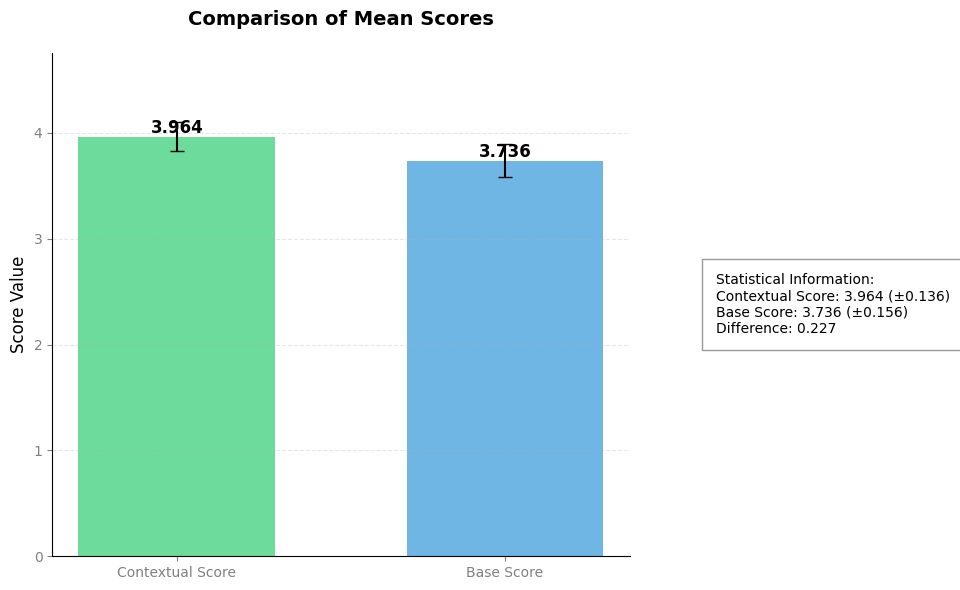

In [103]:
# Calculate means
means = {
    'Contextual Score': df['score_contextual'].mean(),
    'Base Score': df['score'].mean()
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
fig.set_facecolor('white')

# Create bar chart
bars = ax.bar(means.keys(), means.values(), 
              color=['#2ecc71', '#3498db'],  # Green and Blue
              width=0.6,
              alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom',
            fontsize=12,
            fontweight='bold')

# Add error bars (standard error)
std_errors = {
    'Contextual Score': df['score_contextual'].std() / np.sqrt(len(df)),
    'Base Score': df['score'].std() / np.sqrt(len(df))
}
ax.errorbar(x=range(len(means)), y=list(means.values()), 
            yerr=list(std_errors.values()),
            fmt='none', color='black', capsize=5)

# Customize the plot
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Set titles and labels
plt.title('Comparison of Mean Scores', pad=20, fontsize=14, fontweight='bold')
plt.ylabel('Score Value', fontsize=12)

# Add statistical annotations
stats_text = 'Statistical Information:\n'
stats_text += f"Contextual Score: {means['Contextual Score']:.3f} (±{std_errors['Contextual Score']:.3f})\n"
stats_text += f"Base Score: {means['Base Score']:.3f} (±{std_errors['Base Score']:.3f})\n"
stats_text += f"Difference: {means['Contextual Score'] - means['Base Score']:.3f}"

plt.text(1.15, 0.5, stats_text,
         transform=ax.transAxes,
         verticalalignment='center',
         bbox=dict(facecolor='white', 
                  edgecolor='gray',
                  alpha=0.8,
                  pad=10))

# Set y-axis to start from 0
ax.set_ylim(0, max(means.values()) * 1.2)

# Add subtle tick lines
ax.tick_params(axis='both', colors='gray')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [98]:
from azure.ai.evaluation import evaluate

result = evaluate(
    data="generated_qa.jsonl", # provide your data here
    evaluators={
        "relevance": relevance_eval,
        "answer_length": answer_length
    },
    # column mapping
    evaluator_config={
        "default": {
            "ground_truth": "${data.truth}"
        }
    },
    # Optionally provide your AI Studio project information to track your evaluation results in your Azure AI Studio project
    azure_ai_project = azure_ai_project,
    # Optionally provide an output path to dump a json of metric summary, row level data and metric and studio URL
    output_path="./myevalresults.json"
)

NameError: name 'answer_length' is not defined